# 1. Data Cleaning

In [1]:
# Import packages
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# Import requests and get .json salary data from levels.fyi
# Code taken from https://towardsdatascience.com/a-beginners-guide-to-grabbing-and-analyzing-salary-data-in-python-e8c60eab186e
import requests
r = requests.get('https://www.levels.fyi/js/salaryData.json')
print(r.headers) # Most recent data is from Tue, 17 Aug 2021
# Load data into pandas DataFrame
data = pd.DataFrame(r.json())

{'Content-Type': 'application/json', 'Content-Length': '3036022', 'Connection': 'keep-alive', 'Content-Encoding': 'gzip', 'Last-Modified': 'Tue, 17 Aug 2021 15:37:18 GMT', 'Server': 'AmazonS3', 'Date': 'Mon, 06 Dec 2021 18:05:55 GMT', 'Cache-Control': 'public, max-age=18000', 'ETag': '"e71e8f415432954bb71175490bc7add3"', 'X-Cache': 'Hit from cloudfront', 'Via': '1.1 6b40574acc577d1185c505c40886acc6.cloudfront.net (CloudFront)', 'X-Amz-Cf-Pop': 'EWR52-C2', 'X-Amz-Cf-Id': 'aFaNrwDI8XM7u1-rOiMyWcyl8MDk6RCFynej1pRnSq4XZwJ7ocyh1A==', 'Age': '1125'}


In [3]:
# View unclean data
data

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber
0,6/7/2017 11:33:27,Oracle,L3,Product Manager,127,"Redwood City, CA",1.5,1.5,,107,20,10,,,7392,807,1
1,6/10/2017 17:11:29,eBay,SE 2,Software Engineer,100,"San Francisco, CA",5,3,,,,,,,7419,807,2
2,6/11/2017 14:53:57,Amazon,L7,Product Manager,310,"Seattle, WA",8,0,,155,,,,,11527,819,3
3,6/14/2017 21:22:25,Microsoft,64,Software Engineering Manager,200,"Redmond, WA",9,9,,169000,100000,30000,,,11521,819,5
4,6/16/2017 10:44:01,Amazon,L5,Software Engineer,173,"Vancouver, BC, Canada",11,1,,120000,0,53000,,,1320,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,8/17/2021 8:16:36,Amazon,L6,Product Manager,241,"Seattle, WA",9,0,Analytic,150,46,45,Female,"Title: Senior Product Manager, Race: Asian, Ac...",11527,819,83870
62638,8/17/2021 8:22:17,Fidelity Investments,L3,Software Engineer,98,"Durham, NC",0,0,Full Stack,85,0,13,Male,"10% profit share into 401k and 7% 401k match, ...",9606,560,83871
62639,8/17/2021 8:24:56,Cisco,Grade 8,Software Engineer,154,"San Jose, CA",5,5,Networking,129,10,15,Male,"Title: Software Engineer 3, Race: Asian",7422,807,83872
62640,8/17/2021 8:26:21,HSBC,GCB5,Software Engineer,159,"New York, NY",12,5,Full Stack,139,0,20,,Title: Senior Software Engineer,10182,501,83874


In [4]:
# View columns
data.columns

Index(['timestamp', 'company', 'level', 'title', 'totalyearlycompensation',
       'location', 'yearsofexperience', 'yearsatcompany', 'tag', 'basesalary',
       'stockgrantvalue', 'bonus', 'gender', 'otherdetails', 'cityid', 'dmaid',
       'rowNumber'],
      dtype='object')

In [5]:
# Change timestamp dtype to datetime64
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [6]:
# Change numerical columns dtype to float64
float_cols = ['totalyearlycompensation', 'yearsofexperience', 'yearsatcompany', 'basesalary', 'stockgrantvalue', 'bonus']
data[float_cols] = data[float_cols].apply(pd.to_numeric)

In [7]:
# Check column dtypes
data.dtypes

timestamp                  datetime64[ns]
company                            object
level                              object
title                              object
totalyearlycompensation           float64
location                           object
yearsofexperience                 float64
yearsatcompany                    float64
tag                                object
basesalary                        float64
stockgrantvalue                   float64
bonus                             float64
gender                             object
otherdetails                       object
cityid                             object
dmaid                              object
rowNumber                           int64
dtype: object

In [8]:
# Replace empty strings with NaN
data = data.replace('', np.NaN)

In [9]:
# Multiply total yearly compensation (in thousands) by 1000 for clearer analysis
data['totalyearlycompensation'] = data['totalyearlycompensation']*1000


In [10]:
# View min and max total yearly compensation
data['totalyearlycompensation'].describe()

count    6.264200e+04
mean     2.163004e+05
std      1.380337e+05
min      1.000000e+04
25%      1.350000e+05
50%      1.880000e+05
75%      2.640000e+05
max      4.980000e+06
Name: totalyearlycompensation, dtype: float64

In [11]:
data['basesalary'].describe()

count    6.033800e+04
mean     1.865890e+03
std      1.899476e+04
min      1.000000e+00
25%      1.110000e+02
50%      1.420000e+02
75%      1.700000e+02
max      1.659870e+06
Name: basesalary, dtype: float64

In [12]:
# Since the max total compensation is less than 5 million and the min total compensation is greater than 10,000,
# We filter the other compensation columns by when base salary is less than 5000 to see when we need to multiply by 1000
in_thousands_cols = ['basesalary', 'stockgrantvalue', 'bonus']
data[in_thousands_cols] = data[in_thousands_cols][data['basesalary'] < 5000]*1000

In [13]:
# Extract Race from other details and view values
data['Race'] = data['otherdetails'].str.extract(r'(?<=Race: )(\w+)')
data['Race'].value_counts()

Asian       11766
White        8030
Hispanic     1130
Two           804
Black         688
American       68
Native         33
Name: Race, dtype: int64

In [14]:
# View full text of 'American' race
data.loc[data['Race'] == 'American'].head(1)['otherdetails'].tolist()

['Race: American Indian or Alaska Native, Academic Level: Bachelor’s degree']

In [15]:
# Replace 'American' with its full text
data.loc[(data['Race'] == 'American'), 'Race'] = 'American Indian or Alaska Native'

In [16]:
# View full text of 'Native' race
data.loc[data['Race'] == 'Native'].head(1)['otherdetails'].tolist()

['Race: Native Hawaiian or Other Pacific Islander, Academic Level: Master’s degree']

In [17]:
# Replace 'Native' with its full text
data.loc[(data['Race'] == 'Native'), 'Race'] = 'Native Hawaiian or Other Pacific Islander'

In [18]:
# View full text of 'Two' race
data.loc[data['Race'] == 'Two'].head(1)['otherdetails'].tolist()

['Race: Two or More Races, Academic Level: Bachelor’s degree']

In [19]:
# Replace 'Two' with its full text
data.loc[(data['Race'] == 'Two'), 'Race'] = 'Two or More Races'

In [20]:
# Extract Education from other details and view values
data['Education'] = data['otherdetails'].str.extract(r'(?<=Academic Level: )(\w+)')
data['Education'].value_counts()

Bachelor     12589
Master       10998
Doctorate     1178
Some           355
High           320
Associate      143
Technical      111
Name: Education, dtype: int64

In [21]:
# View full text of 'Some' education
data.loc[data['Education'] == 'Some'].head(1)['otherdetails'].tolist()

['Race: Black or African American, Academic Level: Some college coursework completed']

In [22]:
# Replace 'Some' with its full text
data.loc[(data['Education'] == 'Some'), 'Education'] = 'Some college coursework completed'

In [23]:
# View full text of 'High' education
data.loc[data['Education'] == 'High'].head(1)['otherdetails'].tolist()

['Race: Hispanic / Latino, Academic Level: High school or equivalent']

In [24]:
# Replace 'High' with its full text
data.loc[(data['Education'] == 'High'), 'Education'] = 'High school or equivalent'

In [25]:
# View full text of 'Technical' education
data.loc[data['Education'] == 'Technical'].head(1)['otherdetails'].tolist()

['Race: White, Academic Level: Technical or occupational certificate']

In [26]:
# Replace 'Technical' with its full text
data.loc[(data['Education'] == 'Technical'), 'Education'] = 'Technical or occupational certificate'

In [27]:
# Create new column that sums the base salary, stock grant value, and bonus
data['sumof3compensation'] = data['basesalary'].fillna(0) + data['stockgrantvalue'].fillna(0) + data['bonus'].fillna(0)

In [28]:
# Total yearly compensation should equal sum of 3 individual compensations
# Check the number of rows with incorrect inputs
data[(data['totalyearlycompensation'] < data['sumof3compensation'])].shape[0] # Incorrect

5806

In [29]:
data[(data['totalyearlycompensation'] == data['sumof3compensation'])].shape[0] # Correct

49917

In [30]:
data[(data['totalyearlycompensation'] > data['sumof3compensation'])].shape[0] # Incorrect

6919

In [31]:
# Create new DataFrame with only rows that have correct compensation data for compensation analysis
data_comp = data[(data['totalyearlycompensation'] == data['sumof3compensation'])]

In [32]:
# Since base salary + stockgrantvalue + bonus = totalyearlycompensation
# For data_comp, we can set all NaN values to 0 for stockgrantvalue and bonus
data_comp[['stockgrantvalue', 'bonus']] = data_comp[['stockgrantvalue', 'bonus']].fillna(0)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [33]:
# Drop duplicate column of sumof3compensation
data_comp = data_comp.drop(columns = ['sumof3compensation'])

In [34]:
# View first 5 rows of data_comp
data_comp.head(5)

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,stockgrantvalue,bonus,gender,otherdetails,cityid,dmaid,rowNumber,Race,Education
5,2017-06-17 00:23:14,Apple,M1,Software Engineering Manager,372000.0,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,180000.0,35000.0,NaN,NaN,7472,807,7,NaN,NaN
9,2017-06-22 12:37:51,Microsoft,65,Software Engineering Manager,300000.0,"Redmond, WA",15.0,11.0,NaN,180000.0,65000.0,55000.0,NaN,NaN,11521,819,12,NaN,NaN
10,2017-06-22 13:55:26,Microsoft,62,Software Engineer,156000.0,"Seattle, WA",4.0,4.0,NaN,135000.0,8000.0,13000.0,NaN,NaN,11527,819,13,NaN,NaN
18,2017-07-07 22:29:34,Microsoft,63,Software Engineer,191000.0,"Seattle, WA",7.0,7.0,NaN,152000.0,17000.0,22000.0,NaN,NaN,11527,819,21,NaN,NaN
21,2017-07-16 16:50:46,Amazon,L5,Software Engineer,218000.0,"Seattle, WA",10.0,0.0,NaN,150000.0,7000.0,61000.0,NaN,NaN,11527,819,25,NaN,NaN


In [35]:
# Download data_comp as .csv file to your local directory
data_comp.to_csv('data_comp.csv')

# 2. Exploratory Data Analysis

###  Distribution of numerical and categorical variables

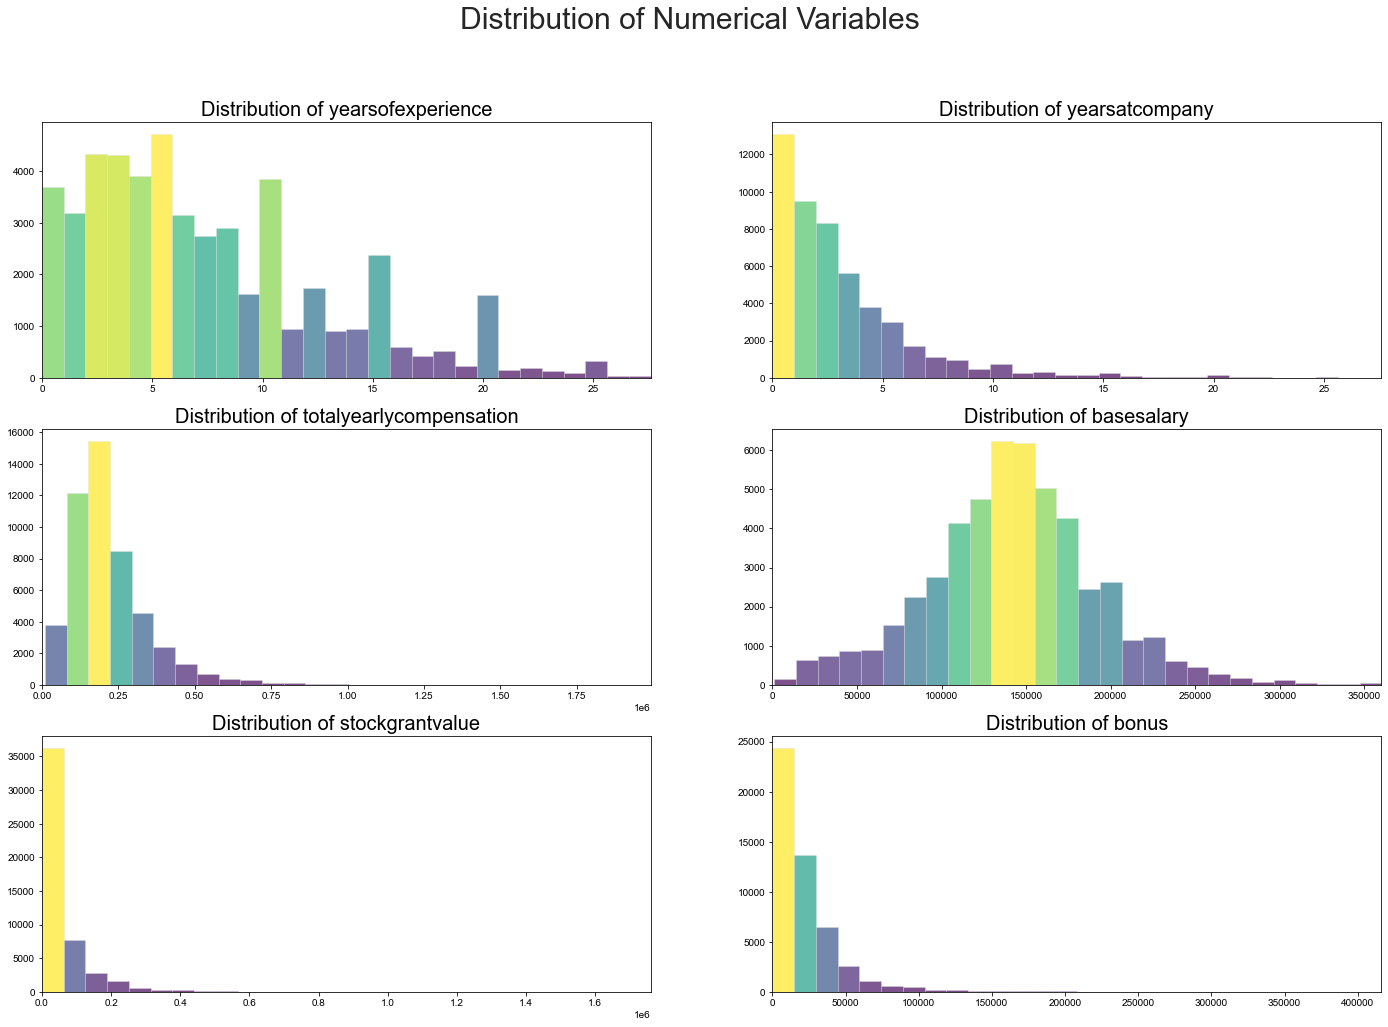

In [36]:
# Plot histograms of numerical variables
nrows = 3
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(24, 16)) # Create figure with 6 subplots
plt.style.use('seaborn-whitegrid') # Style
fig.suptitle("Distribution of Numerical Variables", fontsize = 30) # Title
col_list = ['yearsofexperience','yearsatcompany','totalyearlycompensation','basesalary','stockgrantvalue','bonus'] # xlabels
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].set_title('Distribution of ' + col_list[i*ncols+j], fontsize=20) # Subplot title
        # Plot histogram
        n, bins, patches = axes[i,j].hist(data_comp[col_list[i*ncols+j]], bins =70, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
        n = n.astype('int') # n needs to be an integer
        for k in range(len(patches)):
            patches[k].set_facecolor(plt.cm.viridis(n[k]/max(n))) # Change bin color based on height
        axes[i,j].set_xlim(0,0.4*data_comp[col_list[i*ncols+j]].max()) # Set xlim to remove outliers
plt.savefig('Distribution of Numerical Variables') # Save figure


In [37]:
# Min, Max, and Median of each numerical column plotted above
for col in col_list:
    print('Column: ', col)
    print('Min of column', data_comp[col].min())
    print('Max of column', data_comp[col].max())
    print('Median of column', data_comp[col].median())
    print('-'*80)

Column:  yearsofexperience
Min of column 0.0
Max of column 69.0
Median of column 6.0
--------------------------------------------------------------------------------
Column:  yearsatcompany
Min of column 0.0
Max of column 69.0
Median of column 2.0
--------------------------------------------------------------------------------
Column:  totalyearlycompensation
Min of column 10000.0
Max of column 4980000.0
Median of column 190000.0
--------------------------------------------------------------------------------
Column:  basesalary
Min of column 1000.0
Max of column 900000.0
Median of column 143000.0
--------------------------------------------------------------------------------
Column:  stockgrantvalue
Min of column 0.0
Max of column 4400000.0
Median of column 25000.0
--------------------------------------------------------------------------------
Column:  bonus
Min of column 0.0
Max of column 1040000.0
Median of column 15000.0
-----------------------------------------------------------

In [38]:
# Top ten locations by count
pd.DataFrame(data_comp['location'].value_counts()[:10])

,location
"Seattle, WA",6654
"San Francisco, CA",5427
"New York, NY",3860
"Redmond, WA",1989
"Mountain View, CA",1773
"Sunnyvale, CA",1744
"San Jose, CA",1643
"Austin, TX",1253
"Cupertino, CA",1173
"Menlo Park, CA",1151


In [39]:
# Top ten companies by count
pd.DataFrame(data_comp['company'].value_counts()[:10])

,company
Amazon,5978
Microsoft,3827
Google,3356
Facebook,2368
Apple,1639
Oracle,947
Salesforce,789
IBM,724
Intel,714
Cisco,697


In [40]:
# Top ten job titles by count
pd.DataFrame(data_comp['title'].value_counts()[:10])

,title
Software Engineer,32637
Product Manager,3592
Software Engineering Manager,2855
Data Scientist,2098
Hardware Engineer,1838
Product Designer,1213
Technical Program Manager,1161
Solution Architect,921
Management Consultant,846
Business Analyst,721


In [41]:
# Gender distribution 
pd.DataFrame(data_comp['gender'].value_counts())

,gender
Male,28876
Female,5549
Other,330


In [42]:
# Race distribution 
pd.DataFrame(data_comp['Race'].value_counts())

,Race
Asian,9582
White,6825
Hispanic,941
Two or More Races,680
Black,577
American Indian or Alaska Native,55
Native Hawaiian or Other Pacific Islander,27


In [43]:
# Education distribution 
pd.DataFrame(data_comp['Education'].value_counts())

,Education
Bachelor,10438
Master,9102
Doctorate,1038
Some college coursework completed,287
High school or equivalent,268
Associate,119
Technical or occupational certificate,90


### Correlation Analysis

In [44]:
# List of numerical variables columns 
encoded_df = data_comp[['yearsofexperience','yearsatcompany','totalyearlycompensation','basesalary','stockgrantvalue','bonus']]

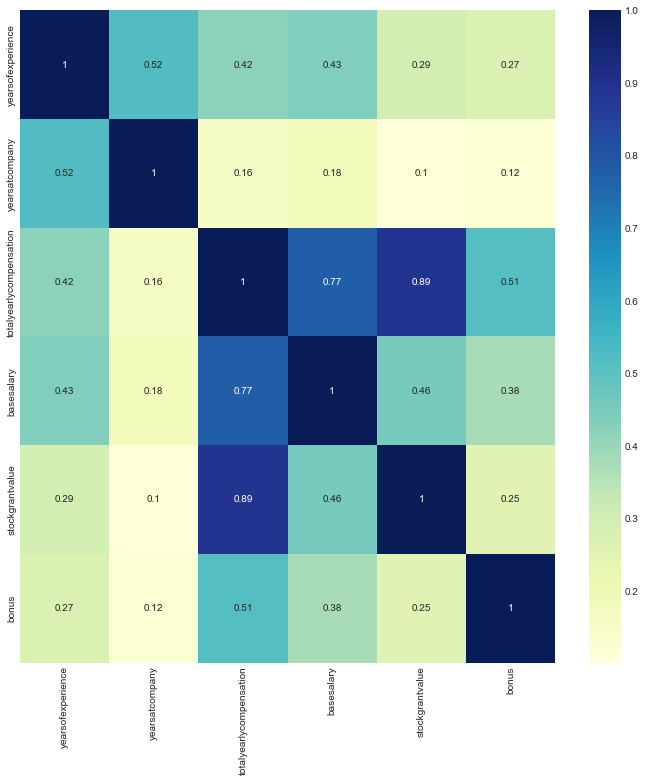

<Figure size 432x288 with 0 Axes>

In [45]:
# Plot heatmap of correlation matrix
fig = plt.figure(figsize = (12,12))
heatmap_plot = sns.heatmap(encoded_df.corr(), cmap="YlGnBu", annot=True)
plt.show()
plt.savefig('Correlation Heat Map') #Save figure

### Salary breakdown by years of experience

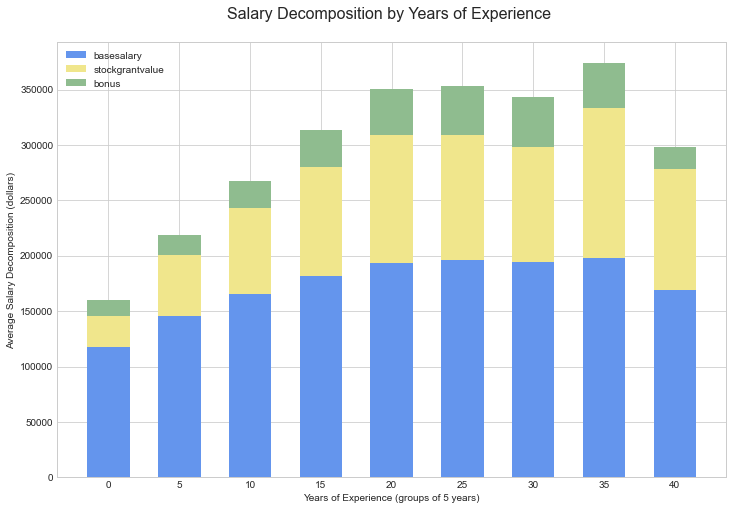

<Figure size 432x288 with 0 Axes>

In [46]:
# Plot average salary decomposition by years of experience
plt.figure(figsize=(12,8))
col_list = ['basesalary','stockgrantvalue','bonus'] # Columns
color_list = ['cornflowerblue', 'khaki','darkseagreen'] # Colors
bottom = np.zeros(len(range(0, 45, 5))) # Initialize bottom
# Loop through 3 columns
for n in range(3):
    avg_sal = []
    x = range(0, 45, 5)
    for i in x:
        # Group by every 5 years of experience
        avg_sal.append(data_comp[(data_comp['yearsofexperience'] >=i) & (data_comp['yearsofexperience'] < i+5)][col_list[n]].mean()) 
    plt.bar(x, avg_sal,label=col_list[n], color = color_list[n], bottom=bottom, width = 3) # Barplot
    bottom += np.array(avg_sal) # Create stacked bar plot
    plt.xticks(x, x) # xticks
plt.legend(col_list) # Legend
plt.xlabel('Years of Experience (groups of 5 years)') # xLabel
plt.ylabel('Average Salary Decomposition (dollars)') # yLabel
plt.title('Salary Decomposition by Years of Experience \n', fontsize = 16) # Title
plt.show()
plt.savefig('Salary Decomposition by Years of Experience') # Save figure

### Salary breakdown by title


In [47]:
# Groupby title, calculate mean compensation, and sort by increasing total yearly compensation
data_comp.groupby('title')[['totalyearlycompensation','basesalary','stockgrantvalue','bonus']].mean().sort_values('totalyearlycompensation')

,totalyearlycompensation,basesalary,stockgrantvalue,bonus
title,,,,
Business Analyst,131352.288488,104762.829404,14123.439667,12466.019417
Recruiter,158359.550562,120839.887640,24696.629213,12823.033708
Mechanical Engineer,161414.285714,120269.047619,29452.380952,11692.857143
Management Consultant,166151.300236,138275.413712,5663.120567,22212.765957
Human Resources,182453.642384,130602.649007,32453.642384,19397.350993
Marketing,199954.545455,141874.125874,38159.090909,19921.328671
Data Scientist,206446.615825,145141.563394,42904.194471,18400.857960
Software Engineer,208425.103410,139293.265312,51278.211845,17853.626252
Product Designer,208854.080791,143014.839242,47769.991756,18069.249794


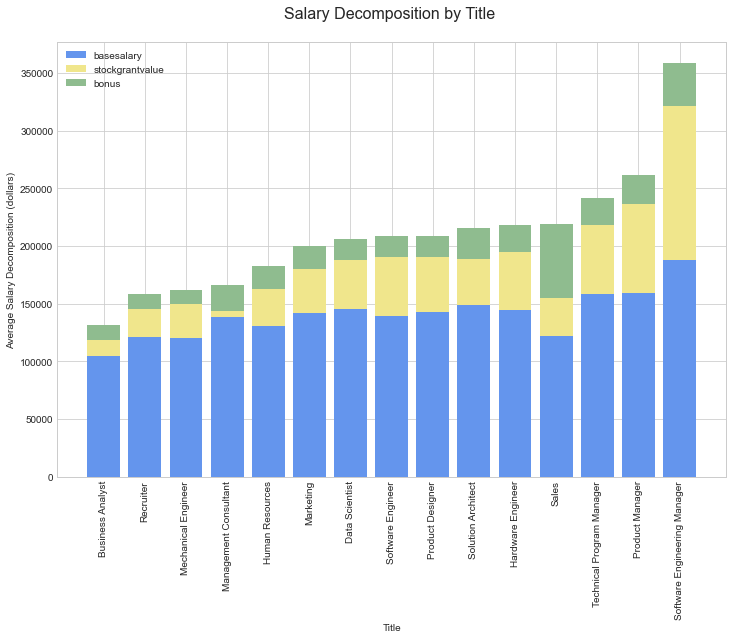

<Figure size 432x288 with 0 Axes>

In [48]:
# Plot average salary decomposition by title
title_df = data_comp.groupby('title')[['totalyearlycompensation','basesalary','stockgrantvalue','bonus']].mean().sort_values('totalyearlycompensation')
plt.figure(figsize=(12,8))
col_list = ['basesalary','stockgrantvalue','bonus'] # Columns
color_list = ['cornflowerblue', 'khaki','darkseagreen'] # Colors
bottom = np.zeros(title_df.shape[0]) # Initialize bottom
# Loop through 3 columns
for n in range(3):
    # Barplot
    plt.bar(title_df.index, title_df[col_list[n]],label=col_list[n], color = color_list[n], bottom = bottom, width = 0.8)
    bottom += np.array(title_df[col_list[n]]) # Create stacked bar plot
plt.legend(col_list) # Legend
plt.xlabel('Title') # xLabel
plt.xticks(rotation = 90) # xLabels rotation to vertical
plt.ylabel('Average Salary Decomposition (dollars)') # yLabel
plt.title('Salary Decomposition by Title \n', fontsize = 16) # Title
plt.show()
plt.savefig('Salary Decomposition by Title') # Save figure

### Salary breakdown by education

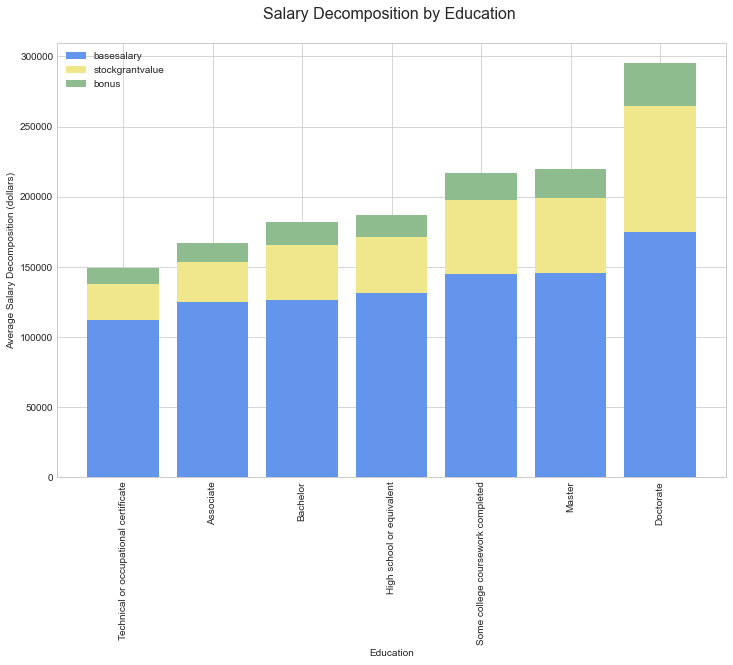

<Figure size 432x288 with 0 Axes>

In [49]:
# Plot average salary decomposition by education
title_df = data_comp.groupby('Education')[['totalyearlycompensation','basesalary','stockgrantvalue','bonus']].mean().sort_values('totalyearlycompensation')
plt.figure(figsize=(12,8))
col_list = ['basesalary','stockgrantvalue','bonus'] # Columns
color_list = ['cornflowerblue', 'khaki','darkseagreen'] # Colors
bottom = np.zeros(title_df.shape[0]) # Initialize bottom
# Loop through 3 columns
for n in range(3):
    # Barplot
    plt.bar(title_df.index, title_df[col_list[n]],label=col_list[n], color = color_list[n], bottom = bottom, width = 0.8)
    bottom += np.array(title_df[col_list[n]]) # Create stacked bar plot
plt.legend(col_list) # Legend
plt.xlabel('Education') # xLabel
plt.xticks(rotation = 90) # xLabels rotation to vertical
plt.ylabel('Average Salary Decomposition (dollars)') # yLabel
plt.title('Salary Decomposition by Education \n', fontsize = 16) # Title
plt.show()
plt.savefig('Salary Decomposition by Education') # Save figure

# 3. Multiple Linear Regression

In [50]:
#Drop any row with NA's
tempData = data_comp.dropna()

# Initialize dummy variables
dummyCompanies = pd.get_dummies(tempData['company']) 
temp = tempData['company'].value_counts()[:3].index # Top 3 companies only
dummyCompanies = dummyCompanies[temp].astype('int64')

dummyTitles = pd.get_dummies(tempData['title'])   
temp = tempData['title'].value_counts()[:3].index # Top 3 titles only
dummyTitles = dummyTitles[temp].astype('int64')

dummyGender = pd.get_dummies(tempData['gender']) 
temp = tempData['gender'].value_counts()[:2].index # Male and female only
dummyGender = dummyGender[temp].astype('int64')

dummyLocation = pd.get_dummies(tempData['location'])   
temp = tempData['location'].value_counts()[:3].index # Top 3 locations only                                                                                                                                   
dummyLocation = dummyLocation[temp].astype('int64')

dummyRace = pd.get_dummies(tempData['Race'])  # All races

dummyEducation = pd.get_dummies(tempData['Education'])  # All educations

In [51]:
# Standardizing the outcome variable
y = stats.zscore(tempData['totalyearlycompensation'])

# Predictors
x = tempData[['yearsofexperience','yearsatcompany']]
temp = [x, dummyCompanies, dummyTitles, dummyGender, dummyLocation, dummyRace, dummyEducation]

# Combining columns into single dataframe
x = pd.concat(temp,axis=1)

In [52]:
# Inspect formatted data
x.head()

,yearsofexperience,yearsatcompany,Amazon,Microsoft,Google,Software Engineer,Product Manager,Software Engineering Manager,Male,Female,...,Native Hawaiian or Other Pacific Islander,Two or More Races,White,Associate,Bachelor,Doctorate,High school or equivalent,Master,Some college coursework completed,Technical or occupational certificate
24320,3.0,2.0,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
24322,4.0,4.0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
24323,5.0,0.0,0,0,0,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
24325,15.0,3.0,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
24326,3.0,3.0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [53]:
# Run the MLR

# Split data for model
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=0)
print('Train size:',len(xTrain))
print('Test size:',len(xTest))

# Fit linear model to train set
model = LinearRegression().fit(xTrain,yTrain)

# Use model to make predictions with test set
predictions = model.predict(xTest)

# Compute the model error and score
error = mean_squared_error(yTest, predictions, squared=False)
print('RMSE:',error.round(3))
rSqr = r2_score(yTest,predictions)
print('R^2:',rSqr.round(3))

Train size: 14542
Test size: 3636
RMSE: 0.799
R^2: 0.279


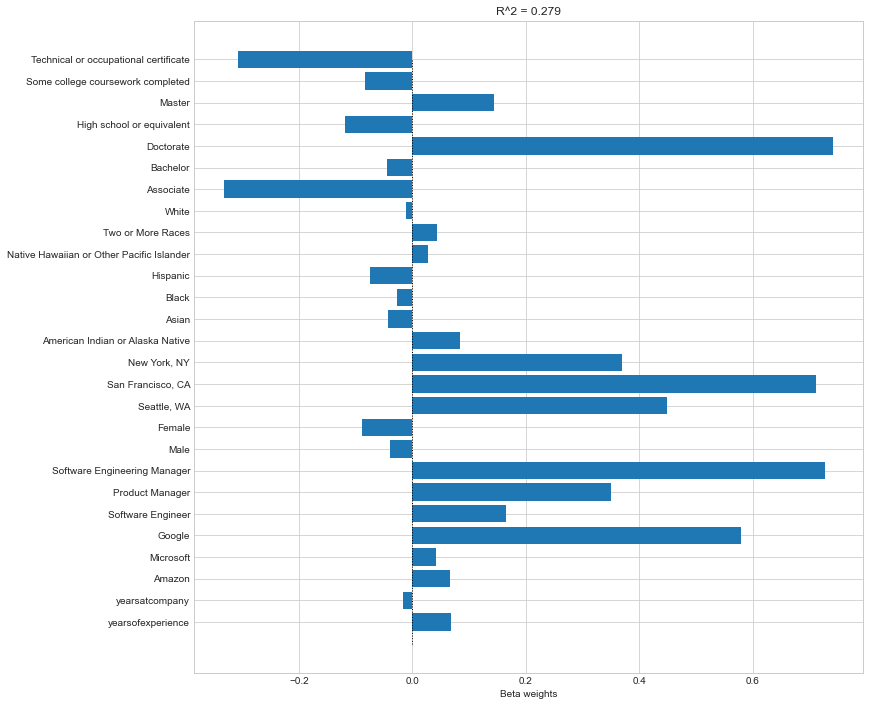

<Figure size 432x288 with 0 Axes>

In [54]:
# Plot the betas:
betas = model.coef_ # Betas
fig = plt.figure(figsize = (12,12))
plt.barh(np.linspace(1,len(betas),len(betas)),betas,tick_label=x.columns) # Horizontal bar plot
plt.vlines(0,0,len(betas),colors='black',linestyles='dotted',linewidth=1) # Black vertical dotted line at 0
plt.title('R^2 = {:.3f}'.format(rSqr)) # Title
plt.xlabel('Beta weights') # xLabel
plt.show()
plt.savefig('Beta distribution of top features') # Save figure